<a href="https://colab.research.google.com/github/washwin/RamSpec_Bacterial_Classification/blob/main/neural_networks_tree_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def advanced_feature_selection(X, y, n_features=100):
    # Combine multiple feature selection techniques

    # Mutual Information Feature Selection
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_mi = selector_mi.fit_transform(X, y)
    mi_features = selector_mi.get_support(indices=True)

    # PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% variance
    X_pca = pca.fit_transform(X)

    # Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X, y)
    rf_importance = rf.feature_importances_
    top_rf_features = np.argsort(rf_importance)[-n_features:]

    # Combine feature sets
    combined_features = list(set(mi_features) | set(top_rf_features))

    return X[:, combined_features], combined_features

In [4]:
def create_hybrid_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,),
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [5]:
def robust_training_pipeline(X, y):
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Performance tracking
    cv_scores = []
    fold_histories = []
    fold_results = []

    # Full results storage
    all_predictions = []
    all_true_labels = []

    # Create a label encoder for consistent label mapping
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(np.unique(y_encoded))

    for fold, (train_index, val_index) in enumerate(skf.split(X, y_encoded), 1):
        print(f"\nFold {fold}")

        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]

        # Feature Selection
        X_train_selected, selected_features = advanced_feature_selection(X_train, y_train)
        X_val_selected = X_val[:, selected_features]

        # Neural Network Model
        model = create_hybrid_model(
            input_shape=X_train_selected.shape[1],
            num_classes=num_classes
        )

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-5
        )

        # Training
        history = model.fit(
            X_train_selected, y_train,
            validation_data=(X_val_selected, y_val),
            epochs=200,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Store training history for this fold
        fold_histories.append({
            'fold': fold,
            'history': history.history
        })

        # Predictions
        y_pred = model.predict(X_val_selected)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Store results
        all_predictions.extend(y_pred_classes)
        all_true_labels.extend(y_val)

        # Store fold-specific results
        fold_results.append({
            'fold': fold,
            'true_labels': y_val,
            'predicted_labels': y_pred_classes,
            'selected_features': selected_features,
            'X_val_selected': X_val_selected,
            'model': model
        })

        # Evaluate this fold
        fold_report = classification_report(y_val, y_pred_classes)
        print(f"Fold {fold} Classification Report:")
        print(fold_report)

    # Final overall report
    print("\nOverall Cross-Validation Results:")
    print(classification_report(all_true_labels, all_predictions))

    return fold_histories, fold_results, le

In [6]:
def analyze_fifth_fold(fold_histories, fold_results, label_encoder=None):
    """Analyze the 5th fold results and plot training/validation metrics"""
    if len(fold_histories) < 5:
        print("Error: 5th fold data not available")
        return

    # Get the 5th fold history and results
    fifth_fold_history = fold_histories[4]  # 0-indexed, so 4 is the 5th fold
    fifth_fold_results = fold_results[4]
    history = fifth_fold_history['history']

    # Print metrics for the 5th fold
    print("\n5th Fold Training/Validation Metrics:")
    print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Final Training Loss: {history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")

    # Plot accuracy - separate plot
    plt.figure(figsize=(10, 6))
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot loss - separate plot
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Get epoch with best validation performance
    best_epoch = np.argmin(history['val_loss'])
    print(f"\nBest Model at Epoch {best_epoch+1}:")
    print(f"Best Validation Accuracy: {history['val_accuracy'][best_epoch]:.4f}")
    print(f"Best Validation Loss: {history['val_loss'][best_epoch]:.4f}")
    print(f"Corresponding Training Accuracy: {history['accuracy'][best_epoch]:.4f}")
    print(f"Corresponding Training Loss: {history['loss'][best_epoch]:.4f}")

    # Create and plot confusion matrix
    plot_confusion_matrix(
        fifth_fold_results['true_labels'],
        fifth_fold_results['predicted_labels'],
        label_encoder
    )

In [7]:









# def plot_confusion_matrix(y_true, y_pred, label_encoder=None):
#     """Create and visualize a normalized confusion matrix for model predictions"""
#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)

#     # Normalize by row (true label count)
#     cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

#     # Get class names if label encoder is provided
#     if label_encoder is not None:
#         class_names = label_encoder.classes_
#     else:
#         class_names = [f"Class {i}" for i in range(len(np.unique(y_true)))]

#     # Create figure - separate plot
#     plt.figure(figsize=(10, 8))

#     # Plot confusion matrix as percentages
#     sns.heatmap(
#         cm_percentage,
#         annot=True,
#         fmt=".2f",
#         cmap='Blues',
#         xticklabels=class_names,
#         yticklabels=class_names
#     )

#     plt.title('Confusion Matrix')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.tight_layout()
#     plt.show()

#     # Calculate and display overall accuracy
#     accuracy = np.trace(cm) / np.sum(cm)
#     print(f"\nOverall Accuracy: {accuracy:.4f}")

def plot_confusion_matrix(y_true, y_pred, label_encoder=None):
    """Create and visualize a normalized confusion matrix for model predictions"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize by row (true label count)
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Get class names if label encoder is provided
    if label_encoder is not None:
        class_names = label_encoder.classes_
    else:
        class_names = [f"Class {i}" for i in range(len(np.unique(y_true)))]

    # Create figure - separate plot
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix as percentages
    sns.heatmap(
        cm_percentage,
        annot=True,
        fmt=".2f",
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate and display overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"\nOverall Accuracy: {accuracy:.4f}")




Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.1364 - loss: 3.2119 - val_accuracy: 0.1620 - val_loss: 2.5592 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2315 - loss: 2.7210 - val_accuracy: 0.2346 - val_loss: 2.5165 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2834 - loss: 2.4141 - val_accuracy: 0.2458 - val_loss: 2.4899 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3404 - loss: 2.2537 - val_accuracy: 0.2570 - val_loss: 2.4705 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2873 - loss: 2.1813 - val_accuracy: 0.1899 - val_loss: 2.4607 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3658 - loss: 2.1187 - val_accuracy: 0.2011 - val_loss: 2.4390 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3652 - loss: 2.0639 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.1385 - loss: 3.1066 - val_accuracy: 0.1397 - val_loss: 2.5886 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1900 - loss: 2.7196 - val_accuracy: 0.1285 - val_loss: 2.5396 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2778 - loss: 2.5360 - val_accuracy: 0.1229 - val_loss: 2.5125 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2758 - loss: 2.4113 - val_accuracy: 0.1229 - val_loss: 2.4824 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3428 - loss: 2.2372 - val_accuracy: 0.1173 - val_loss: 2.4835 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3460 - loss: 2.2022 - val_accuracy: 0.1229 - val_loss: 2.4812 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3364 - loss: 2.1340 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.1225 - loss: 3.4085 - val_accuracy: 0.1341 - val_loss: 2.5736 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2243 - loss: 2.7302 - val_accuracy: 0.1844 - val_loss: 2.5288 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2623 - loss: 2.5240 - val_accuracy: 0.1676 - val_loss: 2.4947 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3168 - loss: 2.3176 - val_accuracy: 0.2067 - val_loss: 2.4682 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3673 - loss: 2.2307 - val_accuracy: 0.2123 - val_loss: 2.4622 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3813 - loss: 2.1225 - val_accuracy: 0.2570 - val_loss: 2.4648 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3978 - loss: 2.0367 - val_accuracy: 0.2

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       1.00      0.80      0.89        20
           2       1.00      1.00      1.00        16
           3       1.00      0.95      0.97        20
           4       0.95      0.95      0.95        20
           5       0.86      0.95      0.90        19
           6       0.95      0.95      0.95        20
           7       0.91      0.95      0.93        22
           8       1.00      0.81      0.89        21

    accuracy                           0.93       179
   macro avg       0.94      0.93      0.93       179
weighted avg       0.94      0.93      0.93       179


Fold 4
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.1313 - loss: 3.2454 - val_accuracy: 0.1564 - val_loss: 2.5723 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2051 - loss: 2.7739 - val_accuracy: 0.1508 - val_loss: 2.5478 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2426 - loss: 2.5148 - val_accuracy: 0.1564 - val_loss: 2.5242 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2677 - loss: 2.4643 - val_accuracy: 0.1676 - val_loss: 2.5090 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2710 - loss: 2.4142 - val_accuracy: 0.1173 - val_loss: 2.5167 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3813 - loss: 2.1694 - val_accuracy: 0.1229 - val_loss: 2.5308 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4203 - loss: 2.0393 - val_accuracy: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        21
           1       1.00      0.85      0.92        20
           2       1.00      1.00      1.00        16
           3       1.00      0.95      0.97        20
           4       0.83      1.00      0.91        20
           5       1.00      0.84      0.91        19
           6       0.95      0.95      0.95        20
           7       0.95      0.86      0.90        21
           8       0.92      1.00      0.96        22

    accuracy                           0.94       179
   macro avg       0.95      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179


Fold 5
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.1652 - loss: 3.1515 - val_accuracy: 0.1676 - val_loss: 2.5621 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2498 - loss: 2.6199 - val_accuracy: 0.1676 - val_loss: 2.5332 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2922 - loss: 2.4256 - val_accuracy: 0.1564 - val_loss: 2.5141 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3350 - loss: 2.3669 - val_accuracy: 0.1620 - val_loss: 2.4999 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3466 - loss: 2.1823 - val_accuracy: 0.1620 - val_loss: 2.4971 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3455 - loss: 2.0478 - val_accuracy: 0.1564 - val_loss: 2.4837 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3775 - loss: 2.0056 - val_accuracy: 

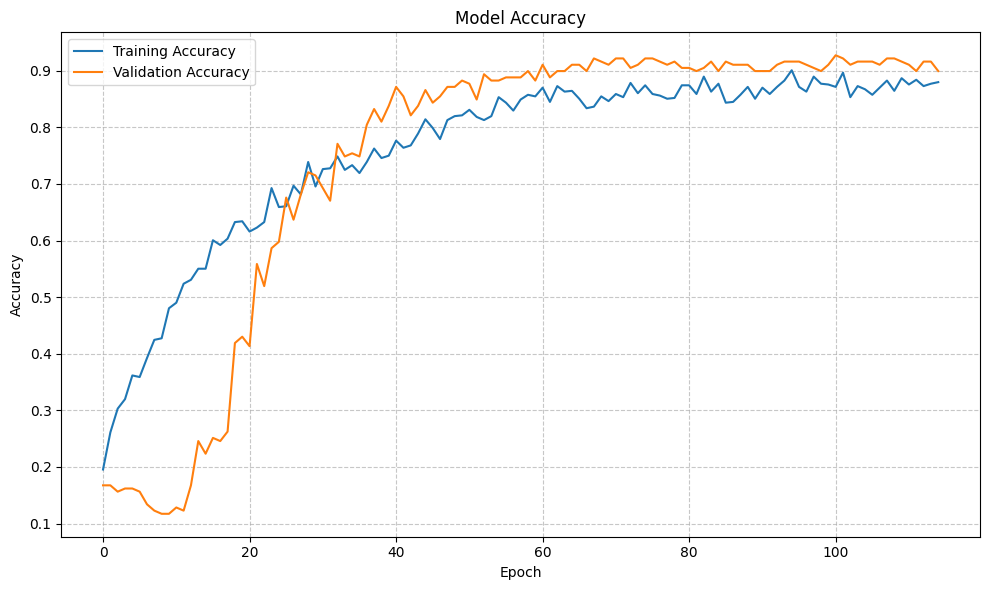

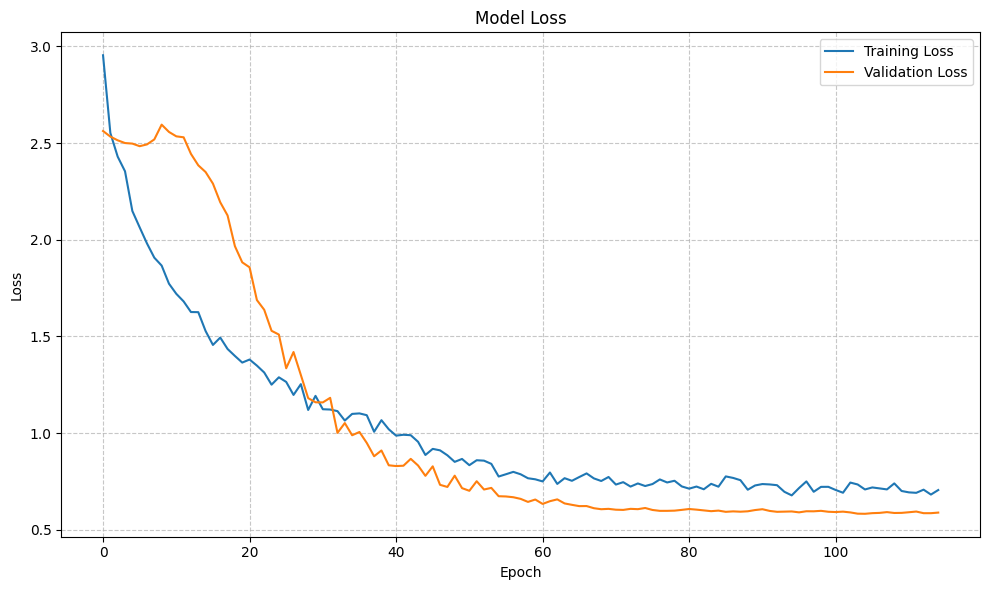


Best Model at Epoch 105:
Best Validation Accuracy: 0.9162
Best Validation Loss: 0.5827
Corresponding Training Accuracy: 0.8673
Corresponding Training Loss: 0.7085


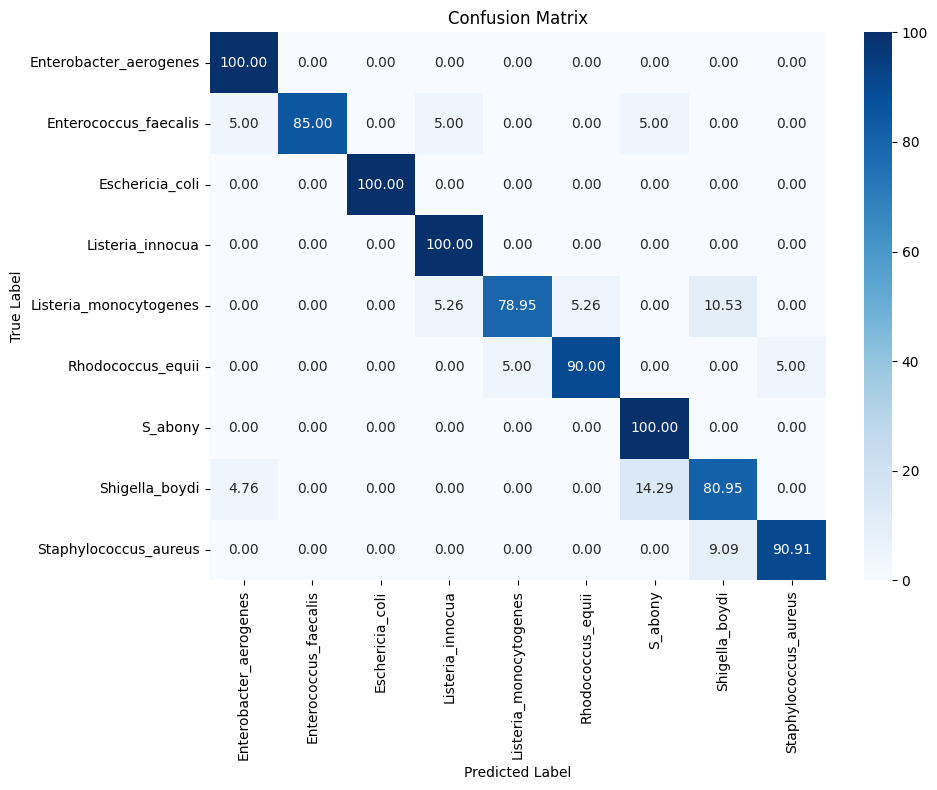


Overall Accuracy: 0.9162


In [8]:
# Example usage (replace with your actual data loading)
df = pd.read_csv('/content/drive/MyDrive/preprocessed_ds used.csv')
X = df.drop(['label', 'Class'], axis=1).values
y = df['label'].values
# --- Updated Code Snippet ---
fold_histories, fold_results, le = robust_training_pipeline(X, y)  # Store the returned values
analyze_fifth_fold(fold_histories, fold_results, le)